In [1]:
import sys
from contextlib import contextmanager
import os
@contextmanager
def add_to_path(directory):
    sys.path.append(directory)
    try:
        yield
    finally:
        sys.path.remove(directory)


# curr_file_path = os.path.dirname(os.path.abspath(__file__))
curr_file_path = 'C:\\Users\\kaleb\\Documents\\GitHub\\BrainControlledWheelchair\\EEG_ML\\tests_gold_electrodes'
dir_above = os.path.dirname(curr_file_path)
# dir_above_above = os.path.dirname(dir_above)
with add_to_path(dir_above):
    from EEGModels import EEGNet
    import read_edf_files as ref

import pandas as pd
import numpy as np
import itertools

from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.models import load_model

from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
from brainflow.data_filter import DataFilter, FilterTypes, NoiseTypes
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
def get_confusion_matrix(model, x, y):
    # send through the model
    probs = model.predict(x)
    # change from one hot encoded to int
    y_int = y.argmax(axis=1)
    preds = probs.argmax(axis=-1)
    # return cm
    return confusion_matrix(y_int, preds)

In [3]:
def get_trained_model(X, Y, dropoutRate=0.5, kernels=1, kernLength=32, F1=8, D=2, F2=16, batch_size=16, epochs=30):
    half = int(len(X) / 2)
    quarter = int(half / 2)
    three_fourths = half + quarter

    X_train = X[:half, :, :]
    X_validate = X[half: three_fourths, :, :]
    X_test = X[three_fourths:, :, :]

    y_train = Y[:half]
    y_validate = Y[half:three_fourths]
    y_test = Y[three_fourths:]

    # convert labels to one-hot encoding
    y_train = np_utils.to_categorical([x - 1 for x in y_train])
    y_validate = np_utils.to_categorical([x - 1 for x in y_validate])
    y_test = np_utils.to_categorical([x - 1 for x in y_test])

    # convert data to NHWC (trials, channels, samples, kernels) format
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], kernels)
    X_validate = X_validate.reshape(X_validate.shape[0], X_validate.shape[1], X_validate.shape[2], kernels)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], kernels)

    print('x_train shape: ', X_train.shape, '\ny_train shape: ', y_train.shape)
    ################################################################
    ## Call EEGNet
    model = EEGNet(nb_classes=5, Chans=X_train.shape[1], Samples=X_train.shape[2],
                   dropoutRate=dropoutRate, kernLength=kernLength, F1=F1, D=D, F2=F2,
                   dropoutType='Dropout')

    # compile the model and set the optimizers
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])

    # set a valid path for your system to record model checkpoints
    chkpt_filepath = '/home/kaleb/tmp/checkpoint.h5'
    checkpointer = ModelCheckpoint(filepath=chkpt_filepath, verbose=1,
                                   save_best_only=True)
    # the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
    # the weights all to be 1
    class_weights = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
              verbose=2, validation_data=(X_validate, y_validate),
              callbacks=[checkpointer], class_weight=class_weights)

    return model, X_test, y_test, history


def get_model_acc(trained_model, X_test, Y_test):
    probs = trained_model.predict(X_test)
    preds = probs.argmax(axis=-1)
    acc = np.mean(preds == Y_test.argmax(axis=-1))

    return acc

In [4]:
def get_best_hyperparams(X, Y): # function will return a df that shows every combination of hyperparam and 
                            # its accuaracy score
    hyperparameter_map = {
        'dropoutRate' : [0.4, 0.5, 0.6],
        'kernels' : [1, 2, 3],
        'kernLength' : [16, 32, 64],
        'F1' : [4, 8, 16],
        'D' : [1, 2, 3],
        'F2' : [8, 16, 32],
        'batch_size' : [8, 16, 32]
    }
    
    df = pd.DataFrame(columns=['combination', 'acc'])
    combinations = list(itertools.product(*(hyperparameter_map[param] for param in hyperparameter_map)))
    for combination in combinations:
        try:
            model, X_test, Y_test = get_trained_model(X, Y, combination[0], combination[1], combination[2],
                                combination[3], combination[4], combination[5], combination[6])

            acc = get_model_acc(model, X_test, Y_test)

            # now add this info to the dataframe
            df.loc[len(df)] = [combination, acc]

        except:
            continue

    # grab the highest value of accuracy in the df
    best_combo_row = df[df['acc'] == df['acc'].max()]
    best_combo = best_combo_row.iloc[0]['combination']

    # translate to the names of the params in best combo row
    dropoutRate = best_combo[0]
    kernels = best_combo[1]
    kernLength = best_combo[2]
    f1 = best_combo[3]
    d = best_combo[4]
    f2 = best_combo[5]
    batch_size = best_combo[6]

    return dropoutRate, kernels, kernLength, f1, d, f2, batch_size

In [5]:
# use subject 13, split by second, to get a confusion matrix and show the 
# improvement of the classification score through the epochs
data_path = os.path.join(curr_file_path, 'test_data', 'kaleb_test1', 'headset_data')
eeg_channels = BoardShim.get_eeg_channels(BoardIds.CYTON_BOARD.value)
board_id = BoardIds.CYTON_BOARD.value

X = []
Y = []
for file in os.listdir(data_path):
    full_dir = os.path.join(data_path, file)
    this_y = []
    if file == 'rest.csv':
        this_y.append(1)
    elif file == 'forward.csv':
        this_y.append(2)
    elif file == 'backward.csv':
        this_y.append(3)
    elif file == 'left.csv':
        this_y.append(4)
    elif file == 'right.csv':
        this_y.append(5)
    else:
        print(f'{file} not in classification')
        continue
    

    data = DataFilter.read_file(full_dir)
    eeg_data = data[eeg_channels, :]
    eeg_data_3d = np.reshape(eeg_data, (1, eeg_data.shape[0], eeg_data.shape[1]))

    samples_per_sec = 230
    num_channels = 8

    # this_x, this_y = ref.split_by_second(eeg_data_3d, this_y, samples_per_sec, num_channels)
    this_x, this_y = ref.convolutional_split(eeg_data_3d, this_y, samples_to_jump_by=20,
                                             trial_len=230, num_channels=8)
    try:
        X = np.vstack((X, this_x))
    except:
        X = this_x

    for label in this_y:
        Y.append(label)


# shuffle the data
combined_data = list(zip(X, Y))
np.random.shuffle(combined_data)
X_shuf, Y_shuf = zip(*combined_data)
X = np.array(X_shuf)
Y = np.array(Y_shuf)

# get the best hyperparameters
# dropoutRate, kernels, kernLength, f1, d, f2, batch_size = get_best_hyperparams(X, Y)
# model, x_test, y_test, history = get_trained_model(X, Y, dropoutRate=dropoutRate, kernels=kernels, kernLength=kernLength, F1=f1, D=d, F2=f2, batch_size=batch_size, epochs=300)
model, x_test, y_test, history = get_trained_model(X, Y, epochs=300)
acc = get_model_acc(model, x_test, y_test)
print(f'Accuracy {acc}')
cm = get_confusion_matrix(model, x_test, y_test)

x_train shape:  (1524, 8, 230, 1) 
y_train shape:  (1524, 5)
Epoch 1/300

Epoch 1: val_loss improved from inf to 1.57801, saving model to /home/kaleb/tmp\checkpoint.h5
96/96 - 2s - loss: 1.5776 - accuracy: 0.3031 - val_loss: 1.5780 - val_accuracy: 0.3360 - 2s/epoch - 17ms/step
Epoch 2/300


C:\Users\kaleb\.conda\envs\eegnet\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 1.57801
96/96 - 1s - loss: 1.5713 - accuracy: 0.3209 - val_loss: 1.5821 - val_accuracy: 0.3360 - 850ms/epoch - 9ms/step
Epoch 3/300

Epoch 3: val_loss improved from 1.57801 to 1.57494, saving model to /home/kaleb/tmp\checkpoint.h5
96/96 - 1s - loss: 1.5708 - accuracy: 0.3196 - val_loss: 1.5749 - val_accuracy: 0.3360 - 886ms/epoch - 9ms/step
Epoch 4/300

Epoch 4: val_loss improved from 1.57494 to 1.55794, saving model to /home/kaleb/tmp\checkpoint.h5
96/96 - 1s - loss: 1.5663 - accuracy: 0.3235 - val_loss: 1.5579 - val_accuracy: 0.3360 - 904ms/epoch - 9ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.55794
96/96 - 1s - loss: 1.5645 - accuracy: 0.3163 - val_loss: 1.5804 - val_accuracy: 0.3084 - 919ms/epoch - 10ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.55794
96/96 - 1s - loss: 1.5554 - accuracy: 0.3196 - val_loss: 1.6035 - val_accuracy: 0.2152 - 888ms/epoch - 9ms/step
Epoch 7/300

Epoch 7: val_loss did not improve fr

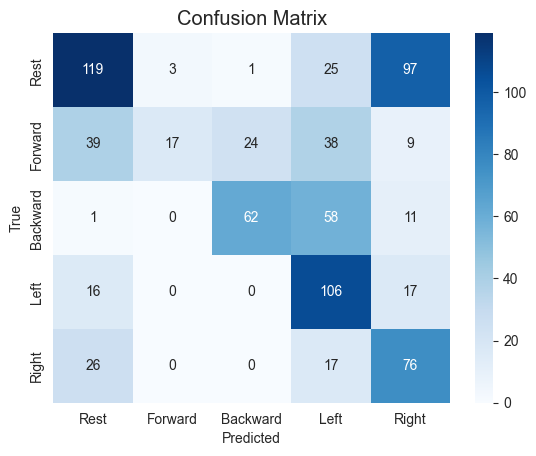

In [6]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Rest", "Forward", "Backward", "Left", "Right"],
            yticklabels=["Rest", "Forward", "Backward", "Left", "Right"])
cm_name =  "poster_cm.png"
sns.set(font_scale=1.2)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
output_path = os.path.join(curr_file_path, 'test_data', cm_name)
plt.savefig(output_path, dpi=300)

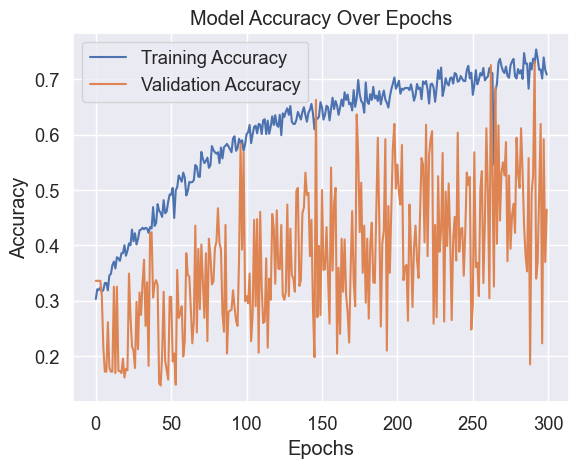

In [7]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# save the model to file
model.save(os.path.join(data_path, 'trained_model.h5'))

C:\Users\kaleb\.conda\envs\eegnet\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
